In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# move into project directory
repo_name = "UMass-CS670-Project"
%cd /content/drive/MyDrive/UMass-Courses/Semester-2/CS670/$repo_name
!ls

/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project
common			  get_dataset.sh	   models		  source-data
config.yaml		  get_info.py		   preprocess_dataset.py  source-zip
datautils		  github-repo-clone.ipynb  README.md		  test_seg.py
demo			  Index.ipynb		   SINet.ipynb		  texture_params.txt
excluded-train-files.txt  index.py		   sinet.py
experiments		  last_run_info.json	   SINet_r18.ipynb


In [3]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

!pip install grad-cam
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#!sudo mv sam_vit_h_4b8939.pth /content/drive/MyDrive/UMass-Courses/Semester-2/CS670/$repo_name/models/weights/sam_vit_h_4b8939.pth


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.3-py3-none-any.whl size=38657 sha256=ccaa38febb80f866a7099f573234098da19fe674d5ecd0a34681b6cdc8016c1e
  Stored in directory: /root/.cache/pip/wheels/2e/ce/70/fe64f851895eae830b3c63ec7fc464cfa7c81aeb7ad4f68063
Successfully built grad-cam
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-o8y54v9l
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-o8y54v9l
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha

In [ ]:
#!unzip -qq ./source-data/TestDataset.zip -d ./source-data/

In [ ]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
# uncomment the lines below  to download the data

import os

!pip install gdown

data_dir="source-data"

if not(os.path.exists("source-data")):
    !gdown https://drive.google.com/uc?id=1IAd2b7EtPqqXbFF3D9PLsHCDjMnr9UkL&export=download
    #echo 'Downloaded data! Unzipping to data folder'
    !unzip -qq -d . ./COD10K-v3.zip
    os.rename("./COD10K-v3.zip", "./source-data/COD10K-v3.zip")
else:
    print("\nThe data directory exists!")

Downloading...
From (original): https://drive.google.com/uc?id=1IAd2b7EtPqqXbFF3D9PLsHCDjMnr9UkL
From (redirected): https://drive.google.com/uc?id=1IAd2b7EtPqqXbFF3D9PLsHCDjMnr9UkL&confirm=t&uuid=c667282e-3fa7-4b49-ad05-110b414ad71c
To: /content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/COD10K-v3.zip
100% 2.38G/2.38G [01:29<00:00, 26.6MB/s]


In [4]:
# setup some imports
from datautils.datareader import read_data
from datautils.dataset import COD10KDataset
from torch.utils.data import DataLoader
import random
import numpy as np
import torch
import argparse
from tqdm import tqdm
from torchvision.io import read_image
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image
import json

from experiments.style_transfer import style_transfer, run_style_transfer_pipeline, deep_style_transfer
from common.visualizer import layer_visualizer
from common.utils import init_config

In [5]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [6]:
config_params = init_config()
print(config_params)

{'data_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/source-data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/output', 'root_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project', 'use_gpu': True}


masks 0.0 1.0 0.0 1.0
ns torch.Size([1, 3, 512, 512])


<ipython-input-6-920325382de5>:35: UserWarning: Using a target size (torch.Size([512, 64, 64])) that is different to the input size (torch.Size([1, 512, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return content_weight * F.mse_loss(curr_content, orig_content)




Iteration [50]
Losses:  3.7298026084899902 1.3045175819570431e-06 3.7298038005828857
rs min max tensor(0.) tensor(1.)


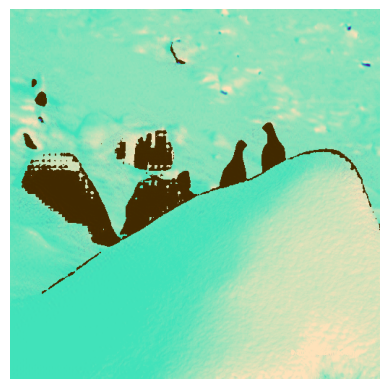



Iteration [100]
Losses:  3.2675061225891113 1.304147644987097e-06 3.267507314682007
rs min max tensor(0.) tensor(1.)


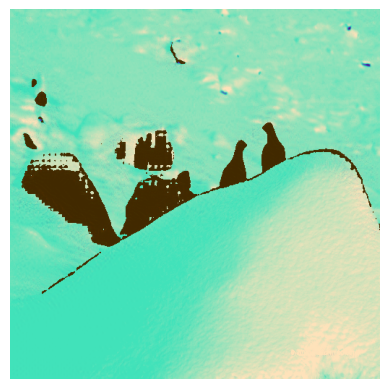



Iteration [150]
Losses:  3.001112937927246 1.3033262575845583e-06 3.0011141300201416
rs min max tensor(0.) tensor(1.)


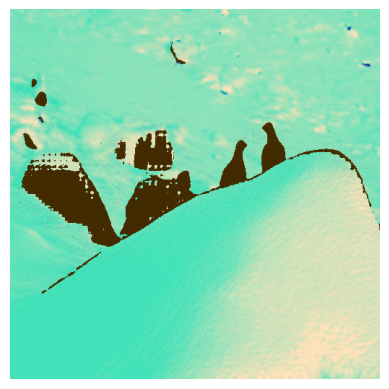

ns size tensor(-0.0021, device='cuda:0') tensor(1.0023, device='cuda:0')
ns size tensor(0., device='cuda:0') tensor(1., device='cuda:0')


Iteration [160]
ns size tensor(0.) tensor(1.) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


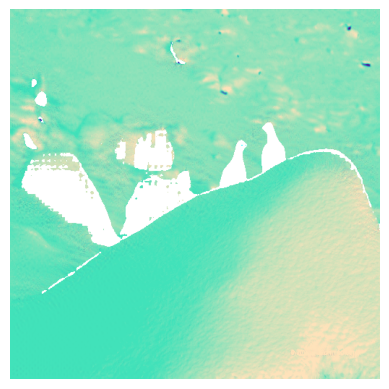

In [ ]:

param_dict = {
    'moss': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'snow': {
        'epochs': 200,
        'style_weights': 1.5
    },
    'wet-sand': {
        'epochs': 200,
        'style_weights': 3.5
    },
    'sand-with-moss': {
        'epochs': 100,
        'style_weights': 2.5
    },
    'rain': {
        'epochs': 100,
        'style_weights': 4.5
    },
    'wood': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'grass': {
        'epochs': 100,
        'style_weights': 0.1
    },
    'foliage-texture': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'blue-coral': {
        'epochs': 100,
        'style_weights': 1.1
    }
}

with open("./last_run_info.json") as fp:
    last_run = json.load(fp)["last_batch"]

selected_textures = ['moss', 'wet-sand', 'sand-with-moss', 'rain', 'foliage-texture']



'''
for texture in selected_textures:

    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type = int, default = 1)
    parser.add_argument('--model_name', type=str, default='vgg')
    parser.add_argument('--lr', type=float, default=0.05)
    parser.add_argument('--max_iter', type=int, default=param_dict[texture]['epochs'])
    args = parser.parse_args(args=[])

    style_img = read_image(f'./source-data/Textures/{texture}.jpg')
    #img = read_image('./source-data/Mini-Set/bgm-bird-1.jpg')
    #print(img.size())
    #layer_visualizer(img, args)

    run_style_transfer_pipeline(args, texture, param_dict[texture]['style_weights'], last_run)
'''

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 1)
parser.add_argument('--model_name', type=str, default='vgg')
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--max_iter', type=int, default=150)
parser.add_argument('--iter_interval', type=int, default=50)
args = parser.parse_args(args=[])

style_img = read_image(f'./source-data/Textures/red-sand.jpg')
img = read_image('./source-data/Mini-Set/bgm-bird-2.jpg')
#img = img[None, :]
#print(img.size())
#layer_visualizer(img, args)
#layer_visualizer(style_img, args)
style_layers = [1, 6, 11, 20, 29] #[2]
#style_layers = [0, 5, 10, 19, 28]
content_layer = 22
style_weights = [1] * 5 #[1.5]*5
content_weight = 1 #1e-4 #1
total_variance_weight = 1e-3 #1e-5 4
lamda = 1e-4
eta = 1e6
#deep_style_transfer(img, style_img, style_layers, content_layer, content_weight, style_weights, lamda, eta, args)
style_transfer(img, style_img, style_layers, content_layer, content_weight, style_weights, total_variance_weight, args)

device cuda
tensor(0.) tensor(0.9922)
tensor(0.0196) tensor(1.)
otuside if ./source-data/segmentation/red-sand.png
inside if ./source-data/segmentation/red-sand.png
otuside if ./source-data/segmentation/bgm-bird-2.png
inside if ./source-data/segmentation/bgm-bird-2.png
masks (512, 512) (512, 512)
mask min max 0.0 1.0 0.0 1.0
bg img sizes before (512, 512, 3) (512, 512, 3)
bg img sizes after (512, 512, 3) (512, 512, 3)


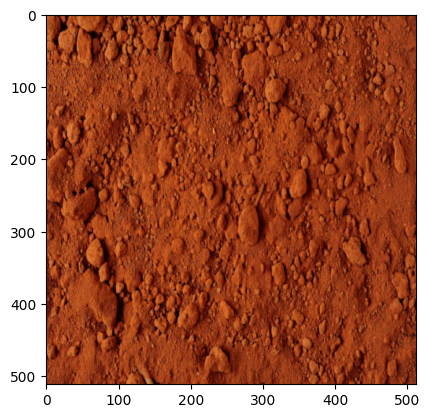

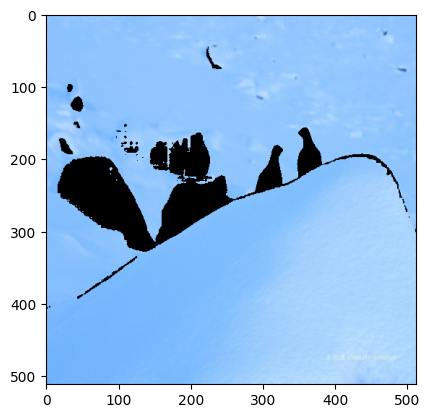

masks 0.0 1.0 0.0 1.0
bgs min max 0.0 0.9921568632125854 0.0 1.0
img szs torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
inp img min max tensor(0., device='cuda:0') tensor(1., device='cuda:0')
Building the style transfer model..
mask sizes torch.Size([1, 1, 256, 256]) torch.Size([1, 3, 512, 512]) 1
augmented style loss feature size torch.Size([128, 256, 256]) torch.Size([1, 1, 256, 256])
inp devices 0 -1
mask sizes torch.Size([1, 1, 128, 128]) torch.Size([1, 3, 512, 512]) 1
augmented style loss feature size torch.Size([256, 128, 128]) torch.Size([1, 1, 128, 128])
inp devices 0 -1


<ipython-input-28-2edf7428493f>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-28-2edf7428493f>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


mask sizes torch.Size([1, 1, 64, 64]) torch.Size([1, 3, 512, 512]) 1
augmented style loss feature size torch.Size([512, 64, 64]) torch.Size([1, 1, 64, 64])
inp devices 0 -1
mask sizes torch.Size([1, 1, 32, 32]) torch.Size([1, 3, 512, 512]) 1
augmented style loss feature size torch.Size([512, 32, 32]) torch.Size([1, 1, 32, 32])
inp devices 0 -1
Optimizing..


NotImplementedError: Could not run 'aten::dot' with arguments from the 'SparseCUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::dot' is only available for these backends: [CPU, CUDA, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastXPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at aten/src/ATen/RegisterCPU.cpp:30455 [kernel]
CUDA: registered at aten/src/ATen/RegisterCUDA.cpp:44681 [kernel]
Meta: registered at /dev/null:241 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: fallthrough registered at ../aten/src/ATen/core/NamedRegistrations.cpp:11 [kernel]
Conjugate: fallthrough registered at ../aten/src/ATen/ConjugateFallback.cpp:21 [kernel]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: fallthrough registered at ../aten/src/ATen/ZeroTensorFallback.cpp:90 [kernel]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradHIP: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradMPS: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradIPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradVE: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradMTIA: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradMeta: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:19857 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_2.cpp:17623 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastXPU: registered at ../aten/src/ATen/autocast_mode.cpp:355 [kernel]
AutocastCUDA: registered at ../aten/src/ATen/autocast_mode.cpp:169 [kernel]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/BatchRulesLinearAlgebra.cpp:596 [kernel]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1079 [kernel]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:157 [backend fallback]


In [28]:
#from experiments.deep_style_transfer import main

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import numpy as np
import copy
#from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
#from common.sam_utils import show_mask, show_box
from common.sam_utils import get_sam_mask
from common.closed_form_matting import closed_form_matting_with_mask
from common.utils import get_config
import os

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4_2']
style_layers_default = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

unloader = transforms.ToPILImage()  # reconvert into PIL image

device = get_config()['device']

CHECKPOINT_PATH='./models/weights/sam_vit_h_4b8939.pth'

MODEL_TYPE = "vit_h"


def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

class AugmentedStyleLoss(nn.Module):

    def __init__(self, target_features, style_mask, content_mask):
        super(AugmentedStyleLoss, self).__init__()
        #self.input_masks = [mask.detach() for mask in input_masks]
        self.content_mask = content_mask.detach()
        print('augmented style loss feature size', target_features[0].size(), style_mask.size())
        print('inp devices', target_features[0].get_device(), style_mask.get_device())
        self.targets = [
            gram_matrix(ftr[None, :].cpu() * style_mask.detach()) for ftr in target_features
        ]

    def forward(self, input):
        gram_matrices = [
            gram_matrix(input.cpu() * self.content_mask) for _ in self.targets
        ]
        Nl = [
            torch.numel(trgt) for trgt in self.targets
        ]
        self.loss = sum(
            F.mse_loss(gram, target, reduction = 'sum') / (2 * nl * nl)
            for gram, target, nl in zip(gram_matrices, self.targets, Nl)
        )
        return input


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image#.to(device, torch.float)


def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

def get_tensor_from_sparse_scipy(scipy_sparse_matrix):

    cfg = get_config()

    data = torch.tensor(scipy_sparse_matrix.data, dtype = torch.float32)
    col = torch.tensor(scipy_sparse_matrix.col, dtype = torch.long)
    row = torch.tensor(scipy_sparse_matrix.row, dtype = torch.long)
    indices = torch.stack([row, col]).to("cpu")

    i = torch.LongTensor(indices)
    shape = scipy_sparse_matrix.shape

    return torch.sparse_coo_tensor(indices, data, shape)
    #return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_bg_img, content_bg_img,
                               style_bg_mask, content_bg_mask,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    num_pool, num_conv = 0, 0  # increment every time we see a conv
    for layer in cnn.children():
        #print('num conv', num_conv)
        if isinstance(layer, nn.Conv2d):
            num_conv += 1
            name = 'conv_{}_{}'.format(num_pool, num_conv)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}_{}'.format(num_pool, num_conv)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            num_pool += 1
            num_conv = 0
            name = 'pool_{}'.format(num_pool)
            layer = nn.AvgPool2d(
                kernel_size=layer.kernel_size,
                stride=layer.stride,
                padding=layer.padding,
            )
            style_bg_mask = layer(style_bg_mask)
            content_bg_mask = layer(content_bg_mask)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}_{}'.format(num_pool, num_conv)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        #print('layer name', name)

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_bg_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(num_pool), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            print('mask sizes', style_bg_mask.size(), style_bg_img.size(), num_conv)
            target_feature = model(style_bg_img).detach()
            #style_loss = StyleLoss(target_feature)
            style_loss = AugmentedStyleLoss(target_feature, style_bg_mask, content_bg_mask)
            model.add_module("style_loss_{}".format(num_pool), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss) or isinstance(model[i], AugmentedStyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def photorealism_regularization(inp_img, Mc):
    grad = Mc.dot(inp_img.reshape(-1, 3))
    loss = (grad * inp_img.reshape(-1, 3)).sum()
    return loss, 2. * grad.reshape(*inp_img.shape)


def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img,
                       content_bg_mask, style_bg_mask,
                       Mc,
                       num_steps=300, style_weight=1000000, content_weight=1, lamda = 1e2):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img,
        content_bg_mask, style_bg_mask)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = torch.tensor(0.0, requires_grad=True)
            content_score = torch.tensor(0.0, requires_grad=True)

            for sl in style_losses:
                #print('sloss', sl.loss.requires_grad)
                style_score = style_score + sl.loss
            for cl in content_losses:
                #print('closs', cl.loss.requires_grad)
                content_score = content_score + cl.loss

            style_score = style_score * style_weight
            content_score = content_score * content_weight

            loss = style_score + content_score
            loss.backward()

            reg_loss, reg_grad = photorealism_regularization(input_img, Mc)
            input_img.grad += (lamda * reg_grad)
            loss += (lamda * reg_loss)

            run[0] += 1
            if run[0] % 20 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return loss

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

def get_bg_img(img_mask, img, cond):

    bg_img_mask = np.expand_dims((img_mask == cond).astype(float), 2)
    img_bg = img * bg_img_mask

    return img_bg, bg_img_mask


def main(style_filename = 'red-sand.jpg', content_filename = 'bgm-bird-2.jpg'):

    #device = get_config()['device']
    print('device', device)
    style_path = os.path.join('./source-data/Textures', style_filename)
    style_img = image_loader(style_path)
    print(style_img.min(), style_img.max())
    content_path = os.path.join('./source-data/Mini-Set', content_filename)
    content_img = image_loader(content_path)
    print(content_img.min(), content_img.max())
    #style_img = F.interpolate(style_img, size = imsize, mode = 'bilinear', antialias = False)
    #content_img = F.interpolate(content_img, size = imsize, mode = 'bilinear', antialias = False)
    og_content_img = content_img.clone()

    i = style_filename.find('.')
    sfn = style_filename[:i]
    style_mask, np_style_img = get_sam_mask(style_img[0], sfn)
    i = content_filename.find('.')
    cfn = content_filename[:i]
    content_mask, np_content_img = get_sam_mask(content_img[0], cfn)
    print('masks', style_mask.shape, content_mask.shape)
    print('mask min max', style_mask.min(), style_mask.max(), content_mask.min(), content_mask.max())
    print('bg img sizes before', np_style_img.shape, np_content_img.shape)
    style_img_bg, style_mask_bg = get_bg_img(style_mask, np_style_img, 0)
    content_img_bg, content_mask_bg = get_bg_img(content_mask, np_content_img, 0)
    print('bg img sizes after', style_img_bg.shape, content_img_bg.shape)
    plt.imshow(style_img_bg)
    plt.show()
    plt.imshow(content_img_bg)
    plt.show()

    print('masks', style_mask.min(), style_mask.max(), content_mask.min(), content_mask.max())
    print('bgs min max', style_img_bg.min(), style_img_bg.max(), content_img_bg.min(), content_img_bg.max())
    #content_mask_bg = (content_mask == 1).astype(float)
    #style_mask_bg = (style_mask == 1).astype(float)
    #content_img_bg = np_content_img * np.expand_dims(content_mask_bg, 2)
    #style_img_bg = np_style_img * np.expand_dims(style_mask_bg, 2)
    #plt.imshow(content_img_bg/255.0)
    #plt.show()
    #Mc = closed_form_matting_with_mask(np_content_img, content_mask)
    Mc = closed_form_matting_with_mask(content_img_bg, content_mask)
    Mc = get_tensor_from_sparse_scipy(Mc).to(device)
    #print('images', np_style_img.shape, np_content_img.shape, style_mask.shape, content_mask.shape)
    #print('laplacians', Mc.size(), type(Mc))
    #style_mask = torch.from_numpy(style_mask)[None, None, :].float()
    #content_mask = torch.from_numpy(content_mask)[None, None, :].float()
    style_mask_bg = torch.from_numpy(style_mask_bg).float().transpose(2, 0).transpose(2, 1)
    content_mask_bg = torch.from_numpy(content_mask_bg).float().transpose(2, 0).transpose(2, 1)

    style_img = torch.from_numpy(style_img_bg).transpose(2, 0).transpose(2, 1) #/ 255.0
    content_img = torch.from_numpy(content_img_bg).transpose(2, 0).transpose(2, 1) #/ 255.0
    style_img = style_img.to(device, torch.float)[None, :]
    content_img = content_img.to(device, torch.float)[None, :]
    style_mask_bg = style_mask_bg[None, :]
    content_mask_bg = content_mask_bg[None, :]
    print('img szs', style_img.size(), content_img.size(), content_mask_bg.size(), style_mask_bg.size())

    assert style_img.size() == content_img.size(), \
        "we need to import style and content images of the same size"

    '''
    plt.ion()

    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')
    '''

    cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(device, torch.float)
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

    # desired depth layers to compute style/content losses :
    # content_layers_default = ['conv_4']
    # style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    input_img = content_img.clone()
    print('inp img min max', input_img.min(), input_img.max())
    # if you want to use white noise by using the following code:
    #
    # .. code-block:: python
    #
    #    input_img = torch.randn(content_img.data.size())

    # add the original input image to the figure:
    #plt.figure()
    #imshow(input_img, title='Input Image')

    style_weight = 1e8
    content_weight = 1

    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, input_img,
                                content_mask_bg, style_mask_bg,
                                Mc,
                                200, style_weight, content_weight)

    output = output.to("cpu")
    output = (output * content_mask_bg) + (og_content_img[0] * (1 - content_mask_bg))
    plt.figure()
    imshow(output, title='Output Image')

    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()

main()

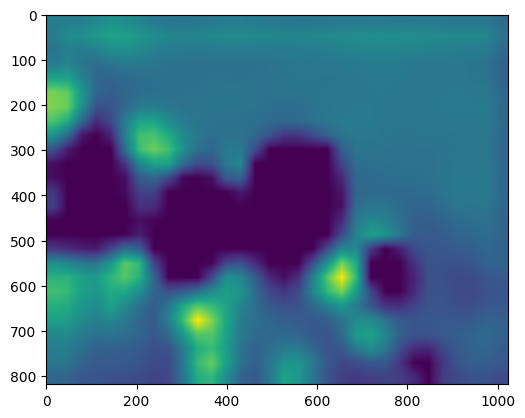

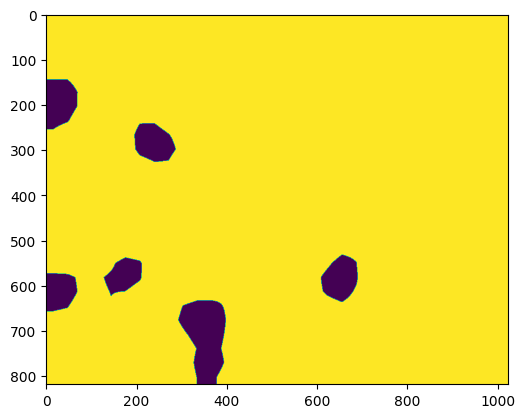

(1, 819, 1023, 3) (819, 1023)


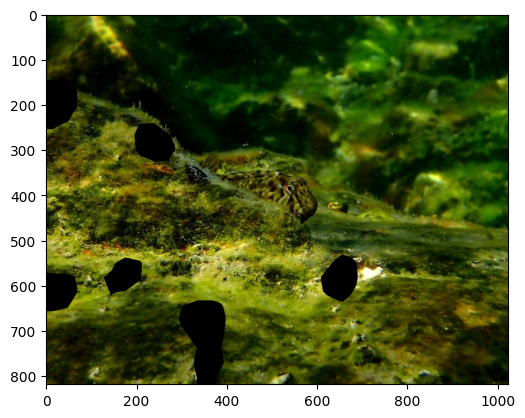

In [ ]:
from models.custom_models import get_model
from common.utils import load_model, init_config
from datautils.datareader import read_data
from datautils.dataset import COD10KDataset, CamouflagedTestDataset
import random
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torch
import argparse
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from common.utils import get_config
import os
from tqdm import tqdm
#from torchvision.io import read_image
from PIL import Image

class SemanticSegmentation:

    def __init__(self, model_path, model_name, num_classes):
        init_config()
        self.model = get_model(num_classes, model_name)
        mf = load_model(model_path)
        self.model.load_state_dict(mf)

    def __prepare_data(self, dataset_name = 'cod10k'):
        dataset = CamouflagedTestDataset(dataset_name)
        smlen = int(0.1 * len(dataset))
        #ridxs = random.sample(range(len(dataset)), smlen)
        ridxs = list(range(smlen))
        smftr_dataset = Subset(dataset, ridxs)
        return dataset, smftr_dataset

    def __image_collate(self, batch):
        batchlist = list(map(list, zip(*batch)))
        return batchlist

    def __convert_to_grascale(self, img):
        imin, imax = img.min(), img.max()
        x = (img - imin) / (imax - imin)
        return x

    def run(self, args, dataset_name = 'cod10k'):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(self.__convert_to_grascale),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
        ])
        tensor_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        cfg = get_config()

        test_dataset, sm_test_dataset = self.__prepare_data(dataset_name)
        test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, collate_fn = self.__image_collate)
        target_layers = [self.model.model.layer4[-1]]
        grad_cam = GradCAM(model = self.model.model, target_layers = target_layers)
        target_class = [ClassifierOutputTarget(1)]
        for i_batch, batch in enumerate(tqdm(test_loader, desc = 'Running through test set')):
            img_batch = list(map(transform, batch[0]))
            img_batch = torch.stack(img_batch, 0)
            #print('img batch', img_batch.size())
            #print(op.size())
            grayscale_cam = grad_cam(input_tensor = img_batch, targets = target_class)
            grayscale_cam = grayscale_cam[0, :, :]
            rgb_imgs = list(map(tensor_transform, batch[0]))
            rgb_imgs = np.transpose(np.stack(rgb_imgs, 0), (0, 2, 3, 1))
            rgb_imgs /= 255.0
            #print(grayscale_cam.shape, rgb_imgs.shape)
            cam_img = show_cam_on_image(rgb_imgs[0], grayscale_cam, use_rgb = True)
            cam_mask = grayscale_cam.copy()
            cam_mask[cam_mask > 0.6] = 1
            cam_mask[cam_mask <= 0.6] = 0
            cam_mask = 1 - cam_mask
            op_path = os.path.join(cfg['output_dir'], f'Test-SemSeg/{dataset_name.upper()}/{batch[2][0]}')
            op_path = op_path.replace("jpg", "png")
            #print(cfg['output_dir'], op_path)
            #print(img_batch.size(), cam_mask.shape)
            plt.imsave(op_path, cam_mask, cmap='binary')
            #plt.imshow(grayscale_cam)
            #plt.show()
            #plt.imshow(cam_mask)
            #plt.show()

    def test_on_single_image(self, args, image_path):
        target_layers = [self.model.model.layer4[-1]]
        grad_cam = GradCAM(model = self.model.model, target_layers = target_layers)
        target_class = [ClassifierOutputTarget(1)]

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(self.__convert_to_grascale),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
        ])
        tensor_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        #img_tensor = read_image(image_path)
        img_arr = [Image.open(image_path)]
        img_tensor = list(map(transform, img_arr))
        img_tensor = torch.stack(img_tensor, 0)
        #print('img size', img_tensor.size())
        grayscale_cam = grad_cam(input_tensor = img_tensor, targets = target_class)
        grayscale_cam = grayscale_cam[0, :, :]
        rgb_imgs = list(map(tensor_transform, img_arr))
        rgb_imgs = np.transpose(np.stack(rgb_imgs, 0), (0, 2, 3, 1))
        rgb_imgs /= 255.0
        #print(grayscale_cam.shape, rgb_imgs.shape)
        cam_img = show_cam_on_image(rgb_imgs[0], grayscale_cam, use_rgb = True)
        cam_mask = grayscale_cam.copy()
        cam_mask[cam_mask > 0.6] = 1
        cam_mask[cam_mask <= 0.6] = 0
        cam_mask = 1 - cam_mask
        #op_path = os.path.join(cfg['output_dir'], f'Test-SemSeg/{dataset_name.upper()}/{batch[2][0]}')
        #op_path = op_path.replace("jpg", "png")
        #print(cfg['output_dir'], op_path)
        #print(img_batch.size(), cam_mask.shape)
        #plt.imsave(op_path, cam_mask, cmap='binary')
        plt.imshow(grayscale_cam)
        plt.show()
        plt.imshow(cam_mask)
        plt.show()
        img_np = np.array(img_arr)
        img_np[0] = img_np[0] * cam_mask[:, :, None]
        print(img_np.shape, cam_mask.shape)
        plt.imshow(img_np[0])
        plt.show()


def run_semantic_segmentation_pipeline(args, dataset_name):
    seg = SemanticSegmentation(args.model_path, 'resnet18', 2)

    #seg.run(args, dataset_name)
    seg.test_on_single_image(args, './source-data/Mini-Set/fish.jpg')

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 1)
parser.add_argument('--model_name', type=str, default='vgg')
parser.add_argument('--lr', type=float, default=0.05)
parser.add_argument('--max_iter', type=int, default=param_dict['grass']['epochs'])
parser.add_argument('--model_path', type=str, default='./models/best_models/resnet-18-best-1.pt')
args = parser.parse_args(args=[])

run_semantic_segmentation_pipeline(args, 'cod10k')


Running epoch 0


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.39s/it]


Running epoch 1


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.41s/it]


Running epoch 2


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.41s/it]


Running epoch 3


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


Running epoch 4


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.49s/it]


Running epoch 5


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.50s/it]


Running epoch 6


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


Running epoch 7


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


Running epoch 8


	Running through validation set: 100%|██████████| 19/19 [00:46<00:00,  2.47s/it]


Running epoch 9


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


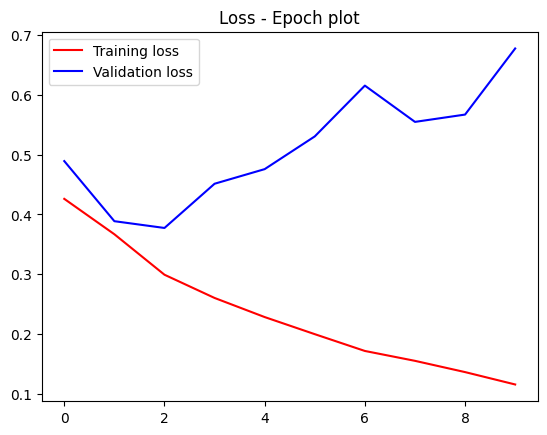

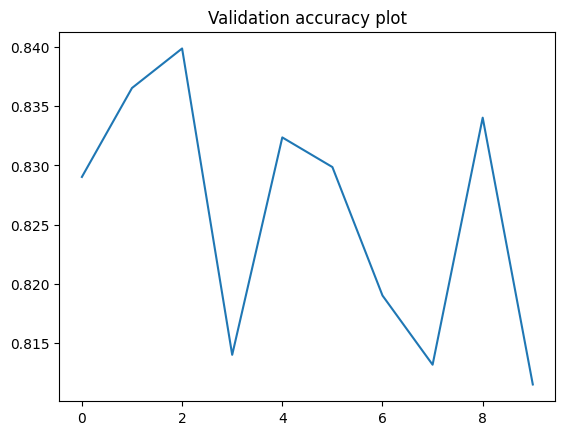

Running through test set: 100%|██████████| 63/63 [02:32<00:00,  2.42s/it]



Test accuracy:  tensor(0.8270)


In [ ]:
'''

from experiments.classification import Classification

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 64)
parser.add_argument('--model_name', type=str, default='resnet18')
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--max_iter', type=int, default=10)
parser.add_argument('--resize_size', type=int, default=224)
args = parser.parse_args(args=[])

classification = Classification()

classification.run_binary_classification_pipeline(args)


'''



In [ ]:
'''

#from experiments.segmentation import run_semantic_segmentation_pipeline
from experiments.evaluate import eval_segmentation
from common.utils import get_config

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 1)
parser.add_argument('--model_name', type=str, default='resnet18')
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--max_iter', type=int, default=5)
parser.add_argument('--resize_size', type=int, default=336)
parser.add_argument('--model_path', type=str, default='./models/checkpoints/resnet-18-best-1.pt')

args = parser.parse_args([])

cfg = get_config()

cod10k_res_path = f'{cfg["output_dir"]}/Test-SemSeg/COD10K'
cod10k_gt_path = f'{cfg["data_dir"]}/TestDataset/COD10K/GT'

camo_res_path = f'{cfg["output_dir"]}/Test-SemSeg/CAMO'
camo_gt_path = f'{cfg["data_dir"]}/TestDataset/CAMO/GT'


chameleon_res_path = f'{cfg["output_dir"]}/Test-SemSeg/CHAMELEON'
chameleon_gt_path = f'{cfg["data_dir"]}/TestDataset/CHAMELEON/GT'

#run_semantic_segmentation_pipeline(args, 'chameleon')
#print('\nEvaluage predicted segmentation masks on chameleon dataset\n')
#eval_segmentation(chameleon_res_path, chameleon_gt_path)

run_semantic_segmentation_pipeline(args, 'camo')
print('\nEvaluage predicted segmentation masks on camo dataset\n')
eval_segmentation(camo_res_path, camo_gt_path)

#run_semantic_segmentation_pipeline(args, 'cod10k')
#print('\nEvaluage predicted segmentation masks on cod10k dataset\n')
#eval_segmentation(cod10k_res_path, cod10k_gt_path)


'''

